In [1]:
!pip install tensorflowjs
!pip install TensorFlow==2.15.0

INFO: pip is looking at multiple versions of tensorstore to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of tensorstore to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of jaxlib to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer

# Import Library

In [2]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow import keras
from tensorflow.keras.applications import MobileNet,EfficientNetB0, InceptionV3,ResNet50
from tensorflow.keras.layers import GlobalMaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score,recall_score, f1_score


2024-11-20 06:26:04.556747: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-20 06:26:04.556886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-20 06:26:04.696141: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Data

In [3]:
train_val_path = '/kaggle/input/skin-disease-dataset/skin-disease-datasaet/train_set'
test_path = '/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set'

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='reflect'
)

train_data = []
val_data = []

train_class_counts = {}
val_class_counts ={}

for folder in sorted(os.listdir(train_val_path)):
    folder_path = os.path.join(train_val_path, folder)
    file = os.listdir(folder_path)
    num_train = int(0.8 * len(file))
    files_train = random.sample(file, num_train)
    files_val = list(set(file) - set(files_train))
    
    train_class_counts[folder] = 0
    val_class_counts[folder] = 0
    
    for file in files_train:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224, 224)) 
        train_data.append((img, folder))

        img_array = np.expand_dims(img, axis=0)

        for _ in range(2):
            augmented_img = datagen.flow(img_array).next()[0].astype(np.uint8)
            train_data.append((augmented_img, folder))
        
        train_class_counts[folder] += 3  

    for file in files_val:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224, 224))
        val_data.append((img, folder))
        
        val_class_counts[folder] += 1 

test_data = []
test_class_counts = {}

for folder in sorted(os.listdir(test_path)):
    folder_path = os.path.join(test_path, folder)
    files_test = os.listdir(folder_path)
    test_class_counts[folder] = 0
    for file in files_test:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224, 224)) 
        test_data.append((img, folder))
        img_array = np.expand_dims(img, axis=0)
        test_class_counts[folder] += 1  
    
for class_name, count in train_class_counts.items():
    print(f"Kelas '{class_name}' dalam data TRAIN {count} gambar.")

for class_name, count in val_class_counts.items():
    print(f"Kelas '{class_name}' dalam data VALIDASI {count} gambar.")
    
for class_name, count in test_class_counts.items():
    print(f"Kelas '{class_name}' dalam data TEST {count} gambar.")


Kelas 'BA- cellulitis' dalam data TRAIN 324 gambar.
Kelas 'BA-impetigo' dalam data TRAIN 192 gambar.
Kelas 'FU-athlete-foot' dalam data TRAIN 297 gambar.
Kelas 'FU-nail-fungus' dalam data TRAIN 309 gambar.
Kelas 'FU-ringworm' dalam data TRAIN 216 gambar.
Kelas 'PA-cutaneous-larva-migrans' dalam data TRAIN 240 gambar.
Kelas 'VI-chickenpox' dalam data TRAIN 324 gambar.
Kelas 'VI-shingles' dalam data TRAIN 312 gambar.
Kelas 'BA- cellulitis' dalam data VALIDASI 28 gambar.
Kelas 'BA-impetigo' dalam data VALIDASI 16 gambar.
Kelas 'FU-athlete-foot' dalam data VALIDASI 25 gambar.
Kelas 'FU-nail-fungus' dalam data VALIDASI 26 gambar.
Kelas 'FU-ringworm' dalam data VALIDASI 18 gambar.
Kelas 'PA-cutaneous-larva-migrans' dalam data VALIDASI 20 gambar.
Kelas 'VI-chickenpox' dalam data VALIDASI 28 gambar.
Kelas 'VI-shingles' dalam data VALIDASI 26 gambar.
Kelas 'BA- cellulitis' dalam data TEST 34 gambar.
Kelas 'BA-impetigo' dalam data TEST 20 gambar.
Kelas 'FU-athlete-foot' dalam data TEST 32 gambar

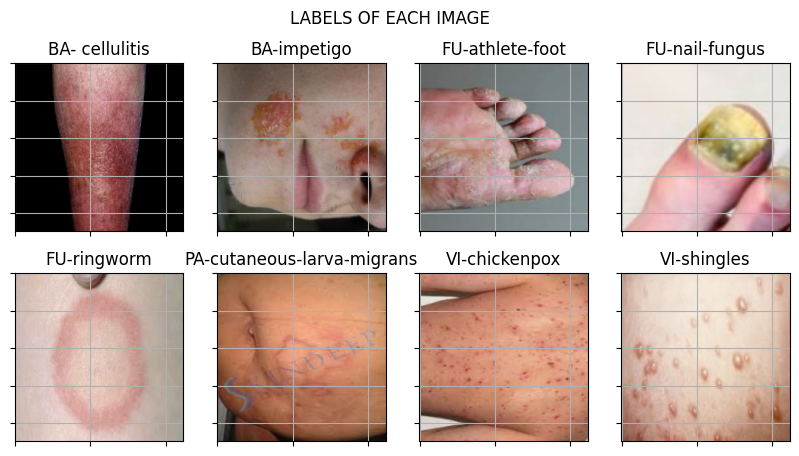

In [4]:
import matplotlib.pyplot as plt

class_images = {}

for img, label in train_data:
    if label not in class_images:
        class_images[label] = img

fig, axes = plt.subplots(2, 4, figsize=(10, 5))
plt.suptitle('LABELS OF EACH IMAGE')

for (label, img), ax in zip(class_images.items(), axes.flatten()):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.show()


In [5]:
tf.keras.backend.clear_session()

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

num_classes = 8
x = GlobalMaxPooling2D()(base_model.output)

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
   
predictions = Dense(num_classes, activation='softmax')(x)


16705208/16705208 [==============================] - 0s 0us/step


In [6]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

In [7]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

X_train = preprocess_input(np.array(X_train))
X_val = preprocess_input(np.array(X_val))

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

y_train_one_hot = to_categorical(y_train_encoded, num_classes)
y_val_one_hot = to_categorical(y_val_encoded, num_classes)



# Training Model

In [8]:
EPOCHS = 100
BATCH_SIZE = 128

best_model_dir = '/kaggle/working/'
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
model_checkpoint = ModelCheckpoint(
    os.path.join(best_model_dir, 'best_model_EfficientNetB0.h5'),
    monitor='val_loss', 
    save_best_only=True,
    mode='min', 
    verbose=1
)

history = model.fit(X_train, y_train_one_hot,
                    validation_data=(X_val, y_val_one_hot),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/100


2024-11-20 06:26:59.568646: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1732084024.057504     121 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 [==============================] - ETA: 0s - loss: 1.1696 - accuracy: 0.6468
Epoch 1: val_loss improved from inf to 1.17133, saving model to /kaggle/working/best_model_EfficientNetB0.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 19s 454ms/step - loss: 1.1696 - accuracy: 0.6468 - val_loss: 1.1713 - val_accuracy: 0.7273
Epoch 2/100
17/18 [===========================>..] - ETA: 0s - loss: 0.3968 - accuracy: 0.8713
Epoch 2: val_loss improved from 1.17133 to 0.32992, saving model to /kaggle/working/best_model_EfficientNetB0.h5
18/18 [==============================] - 3s 170ms/step - loss: 0.3935 - accuracy: 0.8722 - val_loss: 0.3299 - val_accuracy: 0.9037
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 0.2530 - accuracy: 0.9200
Epoch 3: val_loss did not improve from 0.32992
18/18 [==============================] - 3s 146ms/step - loss: 0.2510 - accuracy: 0.9210 - val_loss: 0.3319 - val_accuracy: 0.8824
Epoch 4/100
17/18 [===========================>..] - ETA: 0s - loss: 0.1944 - accuracy: 0.9380
Epoch 4: val_loss improved from 0.32992 to 0.22425, saving model to /kaggle/working/best_model_EfficientNetB0.h5
18/18 [==============================] - 3s 171m

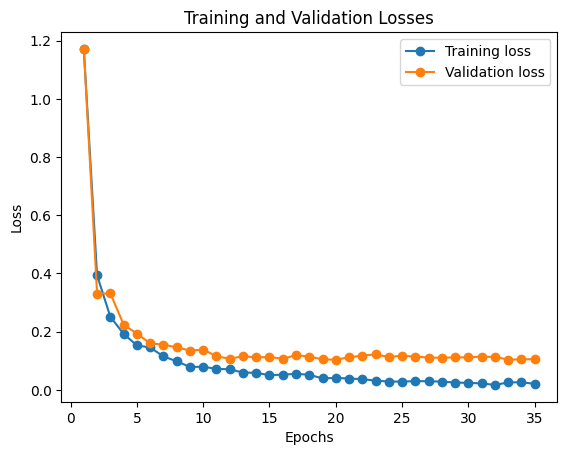

In [9]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss,label='Training loss', marker='o')
plt.plot(epochs, val_loss,label='Validation loss', marker='o')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

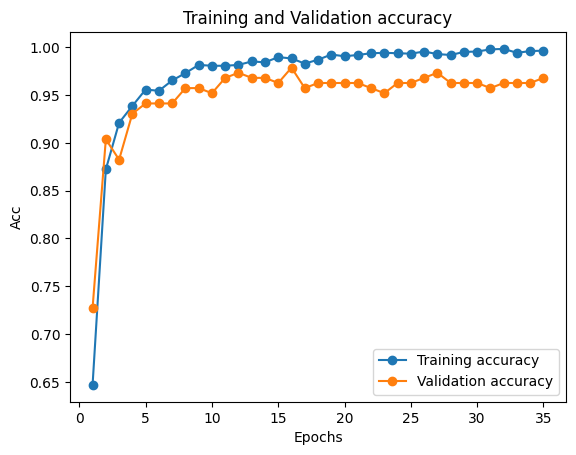

In [10]:
train_loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss,label='Training accuracy', marker='o')
plt.plot(epochs, val_loss,label='Validation accuracy', marker='o')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

# Evaluasi Model

In [11]:
test_path = '/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set'

In [12]:
model = load_model('/kaggle/working/best_model_EfficientNetB0.h5') 

In [13]:
real_label = []
predicted_class = []

for folder in sorted(os.listdir(test_path)):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        img = preprocess_input(np.array([img]))  

        predictions = model.predict(img)
        real_label.append(folder)
        predicted_class_index = np.argmax(predictions)
        predicted_class.append(le.classes_[predicted_class_index])


1/1 [==============================] - 0s 30ms/step


In [14]:
real_labels = np.array(real_label)
predicted_classes = np.array(predicted_class)

accuracy = accuracy_score(real_labels, predicted_classes)
precision = precision_score(real_labels, predicted_classes, average='weighted')
recall = recall_score(real_labels, predicted_classes, average='weighted')
f1 = f1_score(real_labels, predicted_classes, average='weighted')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9402
Precision: 0.9434
Recall: 0.9402
F1 Score: 0.9401


In [15]:
real_labels = np.array(real_label)
predicted_classes = np.array(predicted_class)

conf_matrix = confusion_matrix(real_labels, predicted_classes)

class_names = [str(i) for i in range(len(conf_matrix))] 
print(classification_report(real_labels, predicted_classes, target_names=class_names))


              precision    recall  f1-score   support

           0       0.94      0.94      0.94        34
           1       1.00      1.00      1.00        20
           2       0.97      0.88      0.92        32
           3       0.97      1.00      0.99        33
           4       1.00      0.87      0.93        23
           5       0.92      0.88      0.90        25
           6       0.94      0.94      0.94        34
           7       0.85      1.00      0.92        33

    accuracy                           0.94       234
   macro avg       0.95      0.94      0.94       234
weighted avg       0.94      0.94      0.94       234



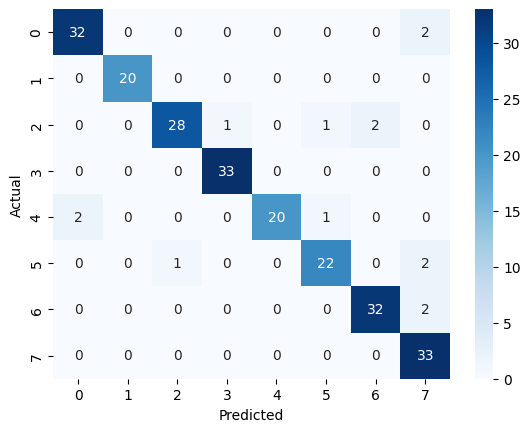

In [16]:
conf_matrix = confusion_matrix(real_label, predicted_class)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()